<a href="https://colab.research.google.com/github/shauryasingh000/Weather_Prediction_using_RNN-s/blob/main/Weather_prediction_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weather-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1868601%2F3051857%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T053152Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d03aaa70f2f7a420dbd23e3d6096e5030521513d540843439df648686151253c318c6d283c5ff6a1a61ef09053d746230df5b3599061a96d571cc00db9aca6daabeafe50627591c35f3610da2f22d101f10f05314e308fbc9cbbf38c5b77dfd65dda7ea57f56d00e2526155805d77ce0bed0f072afecf471f40a73cf4512bccb162a4f71b94ce701747dd71445bc4b0bd2e875a40b74f34ed039715e6d72b9792f4ab37946bd288296a819ae2e9f2b936d7fcd3b81cc5265be6dacfad31e9d80df8be52218951d819768a87f7ff4418d5f15993f6da6742e7ae6e0b38936aaaf2ceb4ff0e49dd1275573952d565bd0ac5e33a6806e081e683d65f26763fb618'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-prediction/seattle-weather.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv('/kaggle/input/weather-prediction/seattle-weather.csv')

In [ ]:
data.sample(10)

,date,precipitation,temp_max,temp_min,wind,weather
309,2012-11-05,0.8,15.0,7.8,4.0,rain
282,2012-10-09,0.0,16.1,8.9,1.6,drizzle
1119,2015-01-24,0.5,14.4,11.1,3.3,rain
991,2014-09-18,0.3,19.4,15.0,3.1,rain
253,2012-09-10,0.3,20.0,11.7,3.9,rain
477,2013-04-22,0.0,16.1,5.0,4.3,sun
161,2012-06-10,0.0,18.9,10.0,2.9,sun
164,2012-06-13,0.0,16.1,11.1,4.3,sun
996,2014-09-23,18.3,18.9,14.4,2.5,rain
956,2014-08-14,0.0,21.1,17.2,0.6,sun


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [ ]:
print(data.isnull().sum())
print()
print(data.duplicated().sum())

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

0


In [ ]:
train = data.iloc[:,2:3].values
train


array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [ ]:
train.shape

(1461, 1)

In [ ]:
len(train)

1461

In [ ]:
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(train)):
    X_train.append(train[i-10:i,0])
    y_train.append(train[i,0])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

In [ ]:
from sklearn.model_selection import train_test_split

WINDOW = 10
X, y = df_to_XY(data, WINDOW)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

928 928
232 232
291 291


In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding additional LSTM layers with Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding the last LSTM layer without return_sequences since it is the last LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.3))

# The output layer
model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 270.6845 - val_loss: 122.8953
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 101.6481 - val_loss: 80.5526
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 75.5369 - val_loss: 69.5330
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 60.3577 - val_loss: 63.6523
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 57.2651 - val_loss: 60.6264
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 52.4486 - val_loss: 59.1722
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 54.5722 - val_loss: 58.3862
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 52.0467 - val_loss: 57.9990
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 51.4634 - val_loss: 57.8187
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 54.7260 - val_loss: 57.7438
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 51.9415 - val_loss: 57.7072
Epoch 12/100
29/29 ━━━━━━━━

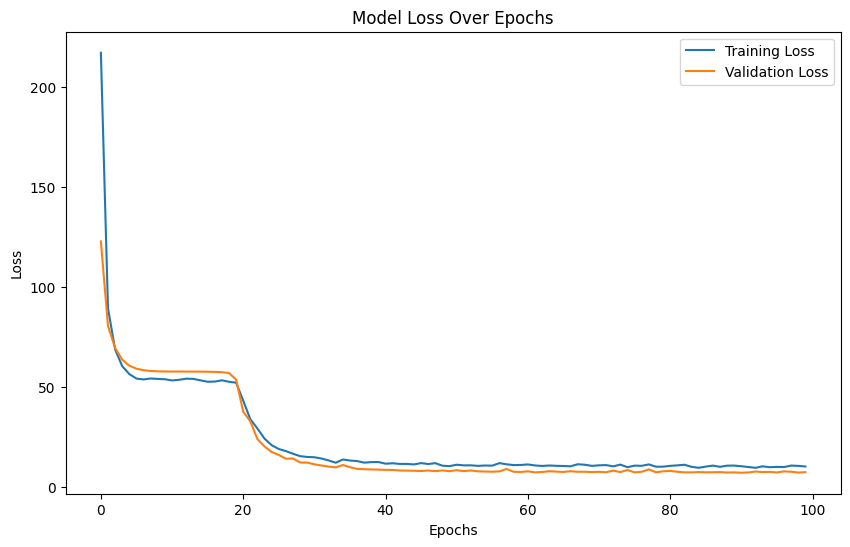

In [ ]:
import matplotlib.pyplot as plt

# Extract the metrics from history.history
history_dict = history.history

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy if available
if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
    plt.figure(figsize=(10, 6))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


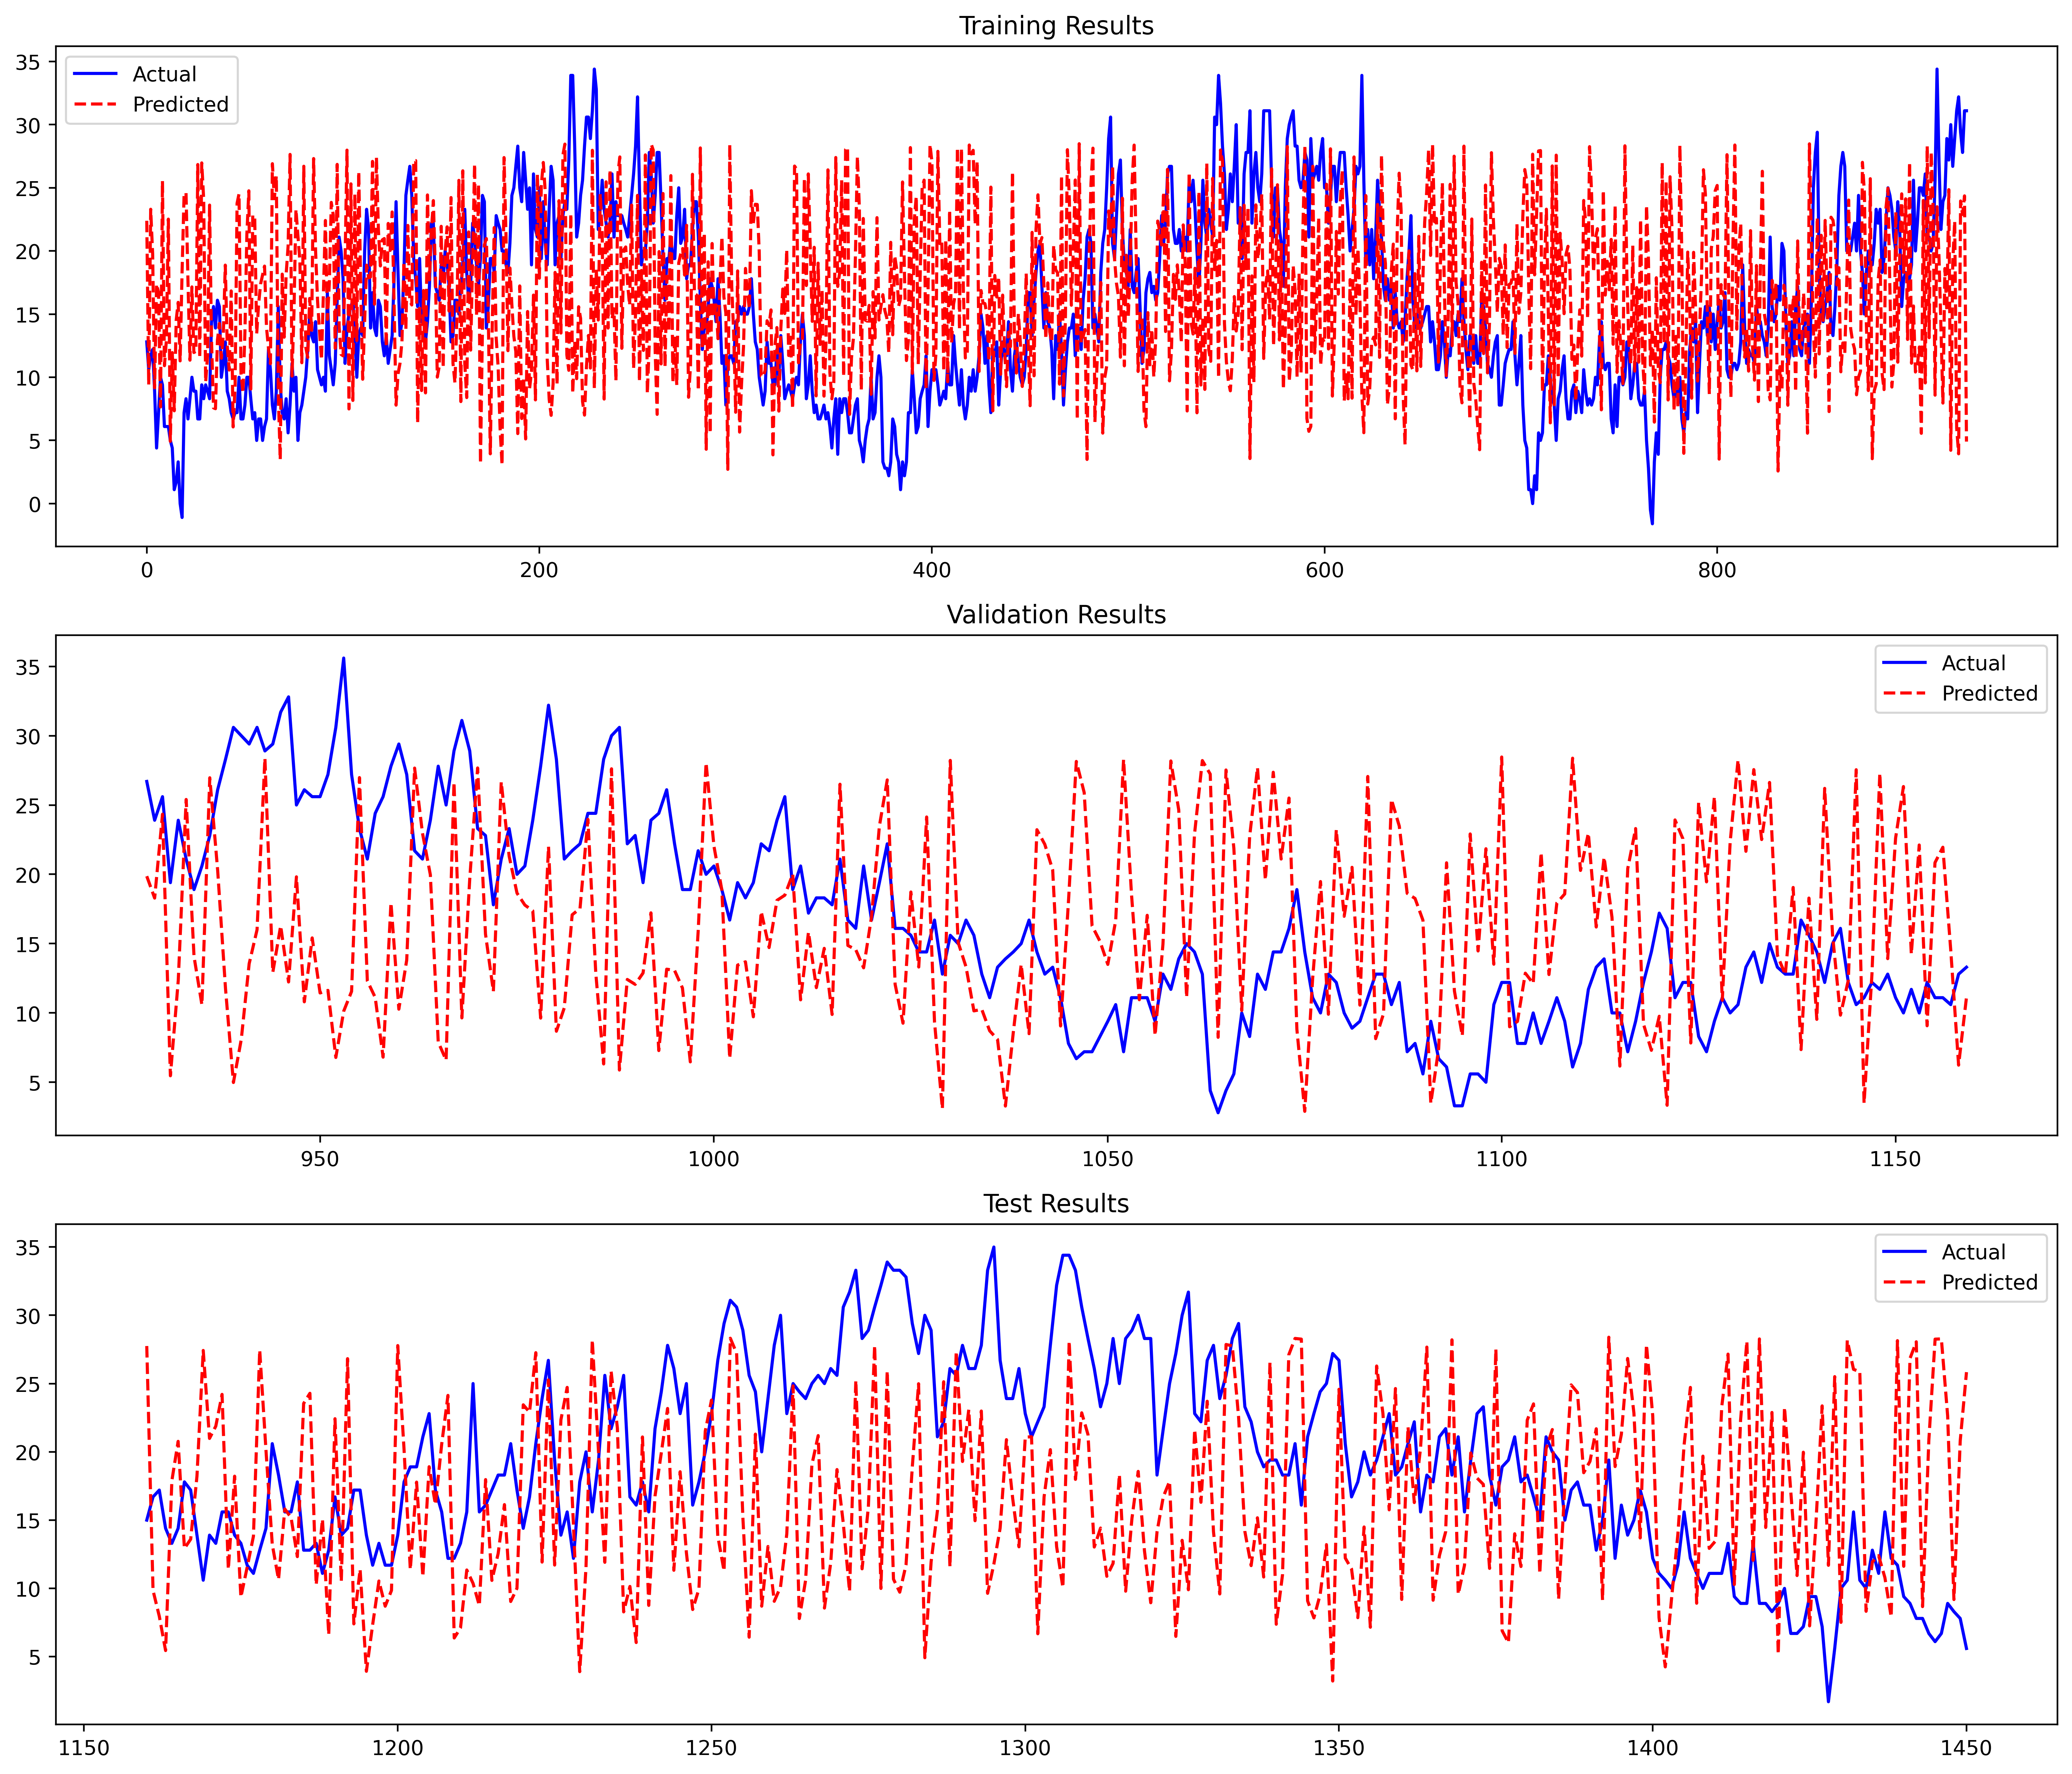

In [ ]:
# Create DataFrames for actual and predicted values
train_df = pd.DataFrame({
    'actual': data['temp_max'][:len(train_pred)],  # Adjust based on your data slicing
    'predicted': train_pred
})

val_df = pd.DataFrame({
    'actual': data['temp_max'][len(train_pred):len(train_pred) + len(val_pred)],  # Adjust based on your data slicing
    'predicted': val_pred
})

test_df = pd.DataFrame({
    'actual': data['temp_max'][len(train_pred) + len(val_pred):len(train_pred) + len(val_pred) + len(test_pred)],  # Adjust based on your data slicing
    'predicted': test_pred
})

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 12), dpi=400)

# Training Results
axes[0].plot(train_df.index, train_df['actual'], label='Actual', color='blue')
axes[0].plot(train_df.index, train_df['predicted'], label='Predicted', color='red', linestyle='--')
axes[0].set_title('Training Results')
axes[0].legend()

# Validation Results
axes[1].plot(val_df.index, val_df['actual'], label='Actual', color='blue')
axes[1].plot(val_df.index, val_df['predicted'], label='Predicted', color='red', linestyle='--')
axes[1].set_title('Validation Results')
axes[1].legend()

# Test Results
axes[2].plot(test_df.index, test_df['actual'], label='Actual', color='blue')
axes[2].plot(test_df.index, test_df['predicted'], label='Predicted', color='red', linestyle='--')
axes[2].set_title('Test Results')
axes[2].legend()

plt.tight_layout()
plt.show()
